In [1]:
import pandas as pd
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pylab import rcParams

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

from src.data.loaders import CommodityLoader
from src.utils.split_series import split_series
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from src.evaluation.evaluation import MetricEvaluator

2025-10-12 15:14:00.931968: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-12 15:14:01.655585: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-12 15:14:03.767632: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
dark_style = {
    'figure.facecolor': '#212946',
    'axes.facecolor': '#212946',
    'savefig.facecolor':'#212946',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'grid.color': '#2A3459',
    'grid.linewidth': '1',
    'text.color': '0.9',
    'axes.labelcolor': '0.9',
    'xtick.color': '0.9',
    'ytick.color': '0.9',
    'font.size': 12 
}
plt.rcParams.update(dark_style)

In [3]:
df_brl = CommodityLoader.load_all_commodities(currency='BRL', preprocessing=True, monthly_aggregation='mean', limit_date=None)

ദ്ദി・ᴗ・)✧ acucar_santos carregado com sucesso
ദ്ദി・ᴗ・)✧ acucar_sp carregado com sucesso
ദ്ദി・ᴗ・)✧ algodao carregado com sucesso
ദ്ദി・ᴗ・)✧ arroz carregado com sucesso
ദ്ദി・ᴗ・)✧ cafe_arabica carregado com sucesso
ദ്ദി・ᴗ・)✧ cafe_robusta carregado com sucesso
ദ്ദി・ᴗ・)✧ milho carregado com sucesso
ദ്ദി・ᴗ・)✧ soja_parana carregado com sucesso
ദ്ദി・ᴗ・)✧ soja_paranagua carregado com sucesso
ദ്ദി・ᴗ・)✧ trigo_parana carregado com sucesso
ദ്ദി・ᴗ・)✧ trigo_rs carregado com sucesso


In [4]:
df_brl.to_parquet("df_brl.parquet", index=False)

In [31]:
train, val, test = split_series(df_brl)
full_train = pd.concat([train, val])

Treino + Val ACUCAR_SANTOS: 45 | Teste ACUCAR_SANTOS: 20
Treino + Val ACUCAR_SP: 185 | Teste ACUCAR_SP: 80
Treino + Val ALGODAO: 243 | Teste ALGODAO: 105
Treino + Val ARROZ: 168 | Teste ARROZ: 72
Treino + Val CAFE_ARABICA: 241 | Teste CAFE_ARABICA: 104
Treino + Val CAFE_ROBUSTA: 201 | Teste CAFE_ROBUSTA: 87
Treino + Val MILHO: 175 | Teste MILHO: 75
Treino + Val SOJA_PARANA: 234 | Teste SOJA_PARANA: 101
Treino + Val SOJA_PARANAGUA: 161 | Teste SOJA_PARANAGUA: 70
Treino + Val TRIGO_PARANA: 179 | Teste TRIGO_PARANA: 77
Treino + Val TRIGO_RS: 179 | Teste TRIGO_RS: 77
Splitted data into TRAIN with size 1605, VALIDATION with size 406 and TEST with size 868


In [32]:
def criar_janelas_array(y_array, n_lags=12):
    """Cria janelas a partir de um array 1D (y já escalado). Retorna X, y.
       Retorna (None, None) se não houver janelas suficientes."""
    if len(y_array) <= n_lags:
        return None, None
    Xs, ys = [], []
    for i in range(len(y_array) - n_lags):
        Xs.append(y_array[i:i+n_lags])
        ys.append(y_array[i+n_lags])
    X = np.array(Xs).reshape(-1, n_lags, 1)
    y = np.array(ys)
    return X, y

In [6]:
evaluator = MetricEvaluator()

### Raw

In [5]:
n_lags = 12
models = {}
scalers = {}
mae_by_uid = {}

In [8]:
# Treinar por série com scaler por série
for uid, df_uid in full_train.groupby("unique_id"):
    y_train_orig = df_uid["y"].values.reshape(-1, 1)  # 2D para scaler
    scaler = MinMaxScaler(feature_range=(0, 1))
    y_train_scaled = scaler.fit_transform(y_train_orig).flatten()  # 1D para criar janelas
    scalers[uid] = scaler

    X_train, y_train = criar_janelas_array(y_train_scaled, n_lags=n_lags)
    if X_train is None:
        print(f"Pulando {uid}: série muito curta para n_lags={n_lags} ({len(y_train_orig)} pontos).")
        continue

    model = Sequential([
        LSTM(64, input_shape=(n_lags, 1)),
        Dense(8, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")

    # Early stopping para evitar overfit e reduzir tempo
    es = EarlyStopping(monitor="loss", patience=10, restore_best_weights=True, verbose=0)

    model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=0, callbacks=[es])
    models[uid] = model

print(f"Modelos treinados: {len(models)} (de {df_brl['unique_id'].nunique()} séries).")

2025-10-11 21:25:27.121399: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models

Modelos treinados: 11 (de 11 séries).


In [9]:
forecasts_list = []
mae_list = []

for uid, df_test_uid in test.groupby("unique_id"):
    if uid not in models:
        print(f"Aviso: sem modelo para {uid}, pulando previsões.")
        continue

    model = models[uid]
    scaler = scalers[uid]

    # histórico (full_train) para montar a janela inicial - usar os dados originais do full_train daquele uid
    hist = full_train[full_train["unique_id"] == uid]["y"].values.reshape(-1, 1)
    if len(hist) < n_lags:
        print(f"Aviso: histórico insuficiente para {uid}. Pulando.")
        continue

    # escalonar o histórico e o test usando o scaler daquele uid
    hist_scaled = scaler.transform(hist).flatten()
    test_y_orig = df_test_uid["y"].values.reshape(-1, 1)
    test_y_scaled = scaler.transform(test_y_orig).flatten()

    janela = hist_scaled[-n_lags:].reshape((1, n_lags, 1))

    preds_scaled = []
    preds_orig = []
    ds_list = []

    for i in range(len(df_test_uid)):
        pred_scaled = model.predict(janela, verbose=0)[0][0]  # previsao na escala
        # inverter para escala original antes de armazenar
        pred_orig = scaler.inverse_transform(np.array([[pred_scaled]]))[0, 0]

        preds_scaled.append(pred_scaled)
        preds_orig.append(pred_orig)
        ds_list.append(df_test_uid.iloc[i]["ds"])

        # atualizar janela com o VALOR REAL escalado (one-step with real update)
        valor_real_scaled = test_y_scaled[i]
        nova_janela = np.append(janela.flatten()[1:], valor_real_scaled)
        janela = nova_janela.reshape((1, n_lags, 1))

    # guardar dataframe de previsões já na escala original
    df_preds = pd.DataFrame({
        "unique_id": uid,
        "ds": ds_list,
        "lstm": preds_orig
    })
    forecasts_list.append(df_preds)

    # calcular MAE na escala original
    mae_uid = mean_absolute_error(test_y_orig.flatten(), np.array(preds_orig))
    mae_by_uid[uid] = mae_uid
    mae_list.append({"unique_id": uid, "mae": mae_uid})

# concat previsões
if len(forecasts_list) > 0:
    forecasts_df = pd.concat(forecasts_list, ignore_index=True)
else:
    forecasts_df = pd.DataFrame(columns=["unique_id", "ds", "lstm"])
    print("Nenhuma previsão gerada.")

# resumo de erro
mae_df = pd.DataFrame(mae_list).sort_values("mae")
print("MAE por série (top 10):")
print(mae_df.head(10))

MAE por série (top 10):
         unique_id         mae
6            MILHO    6.357397
3            ARROZ    6.595429
1        ACUCAR_SP    7.809972
7      SOJA_PARANA    8.315377
0    ACUCAR_SANTOS   15.041424
2          ALGODAO   42.218722
8   SOJA_PARANAGUA   42.857659
5     CAFE_ROBUSTA   78.301843
4     CAFE_ARABICA   95.496001
10        TRIGO_RS  189.292111


In [10]:
forecasts_df.head()

,unique_id,ds,lstm
0,ACUCAR_SANTOS,2023-10-01,162.963455
1,ACUCAR_SANTOS,2023-11-01,166.046219
2,ACUCAR_SANTOS,2023-12-01,168.644608
3,ACUCAR_SANTOS,2024-01-01,169.018661
4,ACUCAR_SANTOS,2024-02-01,169.298706


In [ ]:
def plot_series_and_forecasts(df_brl, full_train, test, forecasts_df):
    unique_ids = df_brl['unique_id'].unique()
    for uid in unique_ids:
        series_data = df_brl[df_brl['unique_id'] == uid].copy()
        train_data = full_train[full_train['unique_id'] == uid].copy()
        test_data = test[test['unique_id'] == uid].copy()
        forecast_data = forecasts_df[forecasts_df['unique_id'] == uid].copy()

        if series_data.empty:
            continue

        fig, ax = plt.subplots(1, 1, figsize=(12, 6))
        ax.plot(series_data['ds'], series_data['y'], linewidth=1.5, label='Série Completa', color='lime')
        if not train_data.empty:
            ax.plot(train_data['ds'], train_data['y'], linewidth=2, label='Treino + Val', color='cyan')
        if not test_data.empty:
            ax.plot(test_data['ds'], test_data['y'], linewidth=2, label='Teste (Real)', color='fuchsia')
        if not forecast_data.empty:
            ax.plot(forecast_data['ds'], forecast_data['lstm'], linewidth=2, linestyle='--', label='Previsão LSTM (orig)',
                     color='red')

        if len(test_data) > 0:
            ax.axvline(x=test_data['ds'].iloc[0], color='orange', linestyle=':', alpha=0.8, linewidth=2, label='Início Teste')

        ax.set_title(f'Série Temporal e Previsões - {uid}')
        ax.set_xlabel('Data')
        ax.set_ylabel('Preço')
        ax.legend(loc='best')
        ax.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

plot_series_and_forecasts(df_brl, full_train, test, forecasts_df)

### Tunned

In [37]:
def criar_janelas_array(y_array, n_lags=12):
    """Cria janelas X,y a partir de um array 1D (y já escalado).
       Retorna (X, y) ou (None, None) se houver dados insuficientes."""
    if y_array is None or len(y_array) <= n_lags:
        return None, None
    Xs, ys = [], []
    for i in range(len(y_array) - n_lags):
        Xs.append(y_array[i:i + n_lags])
        ys.append(y_array[i + n_lags])
    X = np.array(Xs).reshape(-1, n_lags, 1)
    y = np.array(ys)
    return X, y

def mae_from_forecasts(forecasts_df, actual_df, model_col='lstm'):
    """Calcula MAE entre forecasts (já em escala original) e actual_df."""
    df = forecasts_df.merge(actual_df[['unique_id', 'ds', 'y']],
                            on=['unique_id', 'ds'], how='inner')
    if len(df) == 0:
        return np.inf
    return mean_absolute_error(df['y'], df[model_col])

In [38]:
def treinar_e_prever_lstm_single_series(params, train_df_uid, val_df_uid, n_lags=12):
    """
    Treina e prevê apenas para UMA série (uid).
    - train_df_uid e val_df_uid devem ser DataFrames contendo 'ds' e 'y' (originais, não escalados).
    - Retorna um DataFrame de previsões (col 'lstm') já na escala original.
    """

    # scaler fit apenas no treino (para tuning)
    scaler = MinMaxScaler(feature_range=(0, 1))
    y_train = train_df_uid["y"].values.reshape(-1, 1)
    y_train_scaled = scaler.fit_transform(y_train).flatten()

    y_val = val_df_uid["y"].values.reshape(-1, 1) if len(val_df_uid) > 0 else np.array([]).reshape(-1,1)
    y_val_scaled = scaler.transform(y_val).flatten() if len(y_val) > 0 else np.array([])

    # criar janelas para treino (treinar com janelas do treino)
    X_train, y_train_jan = criar_janelas_array(y_train_scaled, n_lags=n_lags)
    if X_train is None:
        return pd.DataFrame(columns=["unique_id", "ds", "lstm"])

    # montar e treinar modelo
    model = Sequential()
    model.add(LSTM(params['n_units'], input_shape=(n_lags, 1)))
    if params.get('dropout', 0.0) > 0:
        model.add(Dropout(params['dropout']))
    model.add(Dense(params['dense_units'], activation=params['activation']))
    model.add(Dense(1))

    optimizer = Adam(learning_rate=params['learning_rate'])
    model.compile(optimizer=optimizer, loss='mse')

    es = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True, verbose=0)

    model.fit(X_train, y_train_jan,
              epochs=params['epochs'],
              batch_size=params['batch_size'],
              verbose=0,
              callbacks=[es])

    # ---- previsão one-step na validação ----
    # usaremos histórico do train para formar a janela inicial (últimos n_lags do train escalado)
    history_scaled = y_train_scaled  # 1D
    if len(history_scaled) < n_lags:
        return pd.DataFrame(columns=["unique_id", "ds", "lstm"])

    janela = history_scaled[-n_lags:].reshape((1, n_lags, 1))

    preds_orig = []
    ds_list = []

    # iterar sobre val_df_uid (ordem temporal presumida)
    for i in range(len(val_df_uid)):
        pred_scaled = model.predict(janela, verbose=0)[0][0]
        # inverter escala
        pred_orig = scaler.inverse_transform(np.array([[pred_scaled]]))[0, 0]
        preds_orig.append(pred_orig)
        ds_list.append(val_df_uid.iloc[i]["ds"])

        # atualizar janela com o VALOR REAL escalado
        if len(y_val_scaled) > 0:
            valor_real_scaled = y_val_scaled[i]
        else:
            # sem validação -> usar a própria predição? (mas para tuning não teremos val vazio)
            valor_real_scaled = pred_scaled

        nova_janela = np.append(janela.flatten()[1:], valor_real_scaled)
        janela = nova_janela.reshape((1, n_lags, 1))

    # montar DataFrame de previsões (originais)
    if len(preds_orig) == 0:
        return pd.DataFrame(columns=["unique_id", "ds", "lstm"])

    uid = train_df_uid["unique_id"].iloc[0]
    df_preds = pd.DataFrame({
        "unique_id": uid,
        "ds": ds_list,
        "lstm": preds_orig
    })
    return df_preds

In [39]:
def objective(trial, train_df_uid, val_df_uid, n_lags=12):
    params = {
        'n_units': trial.suggest_int('n_units', 1, 128),
        'dense_units': trial.suggest_int('dense_units', 1, 64),
        'dropout': trial.suggest_float('dropout', 0.0, 0.9),
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True),
        'batch_size': trial.suggest_categorical('batch_size', [5, 10, 12, 16, 24, 32, 64, 128, 256, 512]),
        'activation': trial.suggest_categorical('activation', ['tanh', 'relu', 'linear', 'sigmoid']),
        'epochs': trial.suggest_int('epochs', 50, 100)
    }

    forecasts_df = treinar_e_prever_lstm_single_series(params, train_df_uid, val_df_uid, n_lags=n_lags)

    mae = mae_from_forecasts(forecasts_df, val_df_uid, model_col='lstm')
    return mae

In [40]:
def optuna_tunning_por_serie(df_brl, train, val, n_lags=12, n_trials=20):
    best_params = {}

    for uid in df_brl['unique_id'].unique():
        print(f"\nTunnando série {uid}")

        df_train_uid = train[train["unique_id"] == uid].reset_index(drop=True)
        df_val_uid = val[val["unique_id"] == uid].reset_index(drop=True)

        if len(df_train_uid) <= n_lags:
            print(f"Pulando {uid}: treino tem {len(df_train_uid)} pontos (<= n_lags={n_lags}).")
            continue

        study = optuna.create_study(direction="minimize")
        study.optimize(lambda trial: objective(trial, df_train_uid, df_val_uid, n_lags=n_lags),
                       n_trials=n_trials, show_progress_bar=True)

        if study.best_value is None or study.best_params is None:
            print(f"Não foi possível encontrar bons parâmetros para {uid}. Pulando.")
            continue

        print("Melhores parâmetros:", study.best_params)
        best_params[uid] = study.best_params

    return best_params

In [ ]:
df_brl = CommodityLoader.load_all_commodities(currency='BRL', preprocessing=True, monthly_aggregation='mean', limit_date=None)
# df_brl = df_brl[df_brl['unique_id'] == 'ALGODAO']
train, val, test = split_series(df_brl)
full_train = pd.concat([train, val])

ദ്ദി・ᴗ・)✧ acucar_santos carregado com sucesso
ദ്ദി・ᴗ・)✧ acucar_sp carregado com sucesso
ദ്ദി・ᴗ・)✧ algodao carregado com sucesso
ദ്ദി・ᴗ・)✧ arroz carregado com sucesso
ദ്ദി・ᴗ・)✧ cafe_arabica carregado com sucesso
ദ്ദി・ᴗ・)✧ cafe_robusta carregado com sucesso
ദ്ദി・ᴗ・)✧ milho carregado com sucesso
ദ്ദി・ᴗ・)✧ soja_parana carregado com sucesso
ദ്ദി・ᴗ・)✧ soja_paranagua carregado com sucesso
ദ്ദി・ᴗ・)✧ trigo_parana carregado com sucesso
ദ്ദി・ᴗ・)✧ trigo_rs carregado com sucesso
Treino + Val ALGODAO: 243 | Teste ALGODAO: 105
Splitted data into TRAIN with size 194, VALIDATION with size 49 and TEST with size 105


In [53]:
best_params = optuna_tunning_por_serie(df_brl, train, val, n_lags=12, n_trials=80)

[I 2025-10-11 23:45:16,704] A new study created in memory with name: no-name-55557261-152d-464d-86f4-367988521bad



Tunnando série ALGODAO


  0%|          | 0/80 [00:00<?, ?it/s]

/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-11 23:45:30,735] Trial 0 finished with value: 13.504261330327283 and parameters: {'n_units': 88, 'dense_units': 45, 'dropout': 0.5498725253002497, 'learning_rate': 0.005157081220774585, 'batch_size': 512, 'activation': 'sigmoid', 'epochs': 92}. Best is trial 0 with value: 13.504261330327283.


/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-11 23:45:40,599] Trial 1 finished with value: 64.69306326832803 and parameters: {'n_units': 13, 'dense_units': 24, 'dropout': 0.6008386104967345, 'learning_rate': 0.0003253979796331979, 'batch_size': 512, 'activation': 'sigmoid', 'epochs': 94}. Best is trial 0 with value: 13.504261330327283.


/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-11 23:45:48,338] Trial 2 finished with value: 94.60381974926513 and parameters: {'n_units': 21, 'dense_units': 29, 'dropout': 0.8910015751871062, 'learning_rate': 5.089646544035179e-05, 'batch_size': 128, 'activation': 'relu', 'epochs': 68}. Best is trial 0 with value: 13.504261330327283.


/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-11 23:45:59,793] Trial 3 finished with value: 56.63655000750613 and parameters: {'n_units': 26, 'dense_units': 45, 'dropout': 0.6872166678362401, 'learning_rate': 0.00013801670900774607, 'batch_size': 64, 'activation': 'sigmoid', 'epochs': 85}. Best is trial 0 with value: 13.504261330327283.


/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-11 23:46:16,652] Trial 4 finished with value: 14.552372410311479 and parameters: {'n_units': 110, 'dense_units': 10, 'dropout': 0.40910020133561603, 'learning_rate': 0.005318197320574445, 'batch_size': 16, 'activation': 'sigmoid', 'epochs': 58}. Best is trial 0 with value: 13.504261330327283.


/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-11 23:46:29,506] Trial 5 finished with value: 12.312301133631044 and parameters: {'n_units': 114, 'dense_units': 20, 'dropout': 0.635968252111999, 'learning_rate': 0.009902112562591674, 'batch_size': 10, 'activation': 'sigmoid', 'epochs': 91}. Best is trial 5 with value: 12.312301133631044.


/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-11 23:46:46,854] Trial 6 finished with value: 14.275901786605303 and parameters: {'n_units': 70, 'dense_units': 46, 'dropout': 0.4079497459334719, 'learning_rate': 0.005645219508557652, 'batch_size': 16, 'activation': 'relu', 'epochs': 59}. Best is trial 5 with value: 12.312301133631044.


/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-11 23:46:54,645] Trial 7 finished with value: 46.11791989895343 and parameters: {'n_units': 18, 'dense_units': 41, 'dropout': 0.6406898155086134, 'learning_rate': 0.07763235935992317, 'batch_size': 256, 'activation': 'tanh', 'epochs': 100}. Best is trial 5 with value: 12.312301133631044.


/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-11 23:47:04,466] Trial 8 finished with value: 11.873885432009033 and parameters: {'n_units': 11, 'dense_units': 12, 'dropout': 0.0596161331438659, 'learning_rate': 0.007094769354536509, 'batch_size': 128, 'activation': 'relu', 'epochs': 58}. Best is trial 8 with value: 11.873885432009033.


/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-11 23:47:19,193] Trial 9 finished with value: 13.895437009060567 and parameters: {'n_units': 113, 'dense_units': 9, 'dropout': 0.21112770690034652, 'learning_rate': 0.0028331053076892853, 'batch_size': 128, 'activation': 'sigmoid', 'epochs': 99}. Best is trial 8 with value: 11.873885432009033.


/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-11 23:47:32,667] Trial 10 finished with value: 36.636993913706306 and parameters: {'n_units': 46, 'dense_units': 64, 'dropout': 0.02756492496030638, 'learning_rate': 0.09104070732349308, 'batch_size': 32, 'activation': 'linear', 'epochs': 73}. Best is trial 8 with value: 11.873885432009033.


/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-11 23:47:44,964] Trial 11 finished with value: 14.532385086502087 and parameters: {'n_units': 54, 'dense_units': 18, 'dropout': 0.01958113349728465, 'learning_rate': 0.024702822898857592, 'batch_size': 10, 'activation': 'relu', 'epochs': 50}. Best is trial 8 with value: 11.873885432009033.


/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-11 23:48:07,880] Trial 12 finished with value: 10.697488906380956 and parameters: {'n_units': 88, 'dense_units': 1, 'dropout': 0.22980882237076625, 'learning_rate': 0.0008900222236588038, 'batch_size': 10, 'activation': 'tanh', 'epochs': 84}. Best is trial 12 with value: 10.697488906380956.


/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-11 23:48:21,365] Trial 13 finished with value: 11.21942063301069 and parameters: {'n_units': 85, 'dense_units': 1, 'dropout': 0.21386419588104452, 'learning_rate': 0.0008989248615471581, 'batch_size': 24, 'activation': 'tanh', 'epochs': 81}. Best is trial 12 with value: 10.697488906380956.


/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-11 23:48:39,350] Trial 14 finished with value: 11.319367362603716 and parameters: {'n_units': 87, 'dense_units': 2, 'dropout': 0.2375200413943227, 'learning_rate': 0.0007163075006760669, 'batch_size': 24, 'activation': 'tanh', 'epochs': 82}. Best is trial 12 with value: 10.697488906380956.


/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-11 23:48:55,470] Trial 15 finished with value: 33.53078475587847 and parameters: {'n_units': 87, 'dense_units': 2, 'dropout': 0.23460558591272324, 'learning_rate': 1.349096377323455e-05, 'batch_size': 12, 'activation': 'tanh', 'epochs': 81}. Best is trial 12 with value: 10.697488906380956.


/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-11 23:49:12,091] Trial 16 finished with value: 12.857348945027223 and parameters: {'n_units': 96, 'dense_units': 2, 'dropout': 0.31416872932228257, 'learning_rate': 0.0011712218685949545, 'batch_size': 24, 'activation': 'tanh', 'epochs': 75}. Best is trial 12 with value: 10.697488906380956.


/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-11 23:49:31,521] Trial 17 finished with value: 8.497321313873869 and parameters: {'n_units': 67, 'dense_units': 34, 'dropout': 0.18512477294426802, 'learning_rate': 0.001116281822020522, 'batch_size': 5, 'activation': 'tanh', 'epochs': 85}. Best is trial 17 with value: 8.497321313873869.


/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-11 23:50:20,830] Trial 18 finished with value: 10.282298885516322 and parameters: {'n_units': 67, 'dense_units': 36, 'dropout': 0.15982983090293984, 'learning_rate': 0.00015414413242828356, 'batch_size': 5, 'activation': 'linear', 'epochs': 87}. Best is trial 17 with value: 8.497321313873869.


/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-11 23:51:17,260] Trial 19 finished with value: 15.549219197369531 and parameters: {'n_units': 38, 'dense_units': 37, 'dropout': 0.13055988125401688, 'learning_rate': 9.111372997343118e-05, 'batch_size': 5, 'activation': 'linear', 'epochs': 68}. Best is trial 17 with value: 8.497321313873869.


/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-11 23:52:10,508] Trial 20 finished with value: 28.47396792043577 and parameters: {'n_units': 63, 'dense_units': 57, 'dropout': 0.35453607107242313, 'learning_rate': 1.8728425999495547e-05, 'batch_size': 5, 'activation': 'linear', 'epochs': 88}. Best is trial 17 with value: 8.497321313873869.


/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-11 23:53:24,237] Trial 21 finished with value: 8.810710417135528 and parameters: {'n_units': 71, 'dense_units': 32, 'dropout': 0.12367313912981157, 'learning_rate': 0.0003463801856877349, 'batch_size': 5, 'activation': 'linear', 'epochs': 77}. Best is trial 17 with value: 8.497321313873869.


/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-11 23:54:02,192] Trial 22 finished with value: 9.067489554120677 and parameters: {'n_units': 68, 'dense_units': 32, 'dropout': 0.11949549239130704, 'learning_rate': 0.0003487848977530601, 'batch_size': 5, 'activation': 'linear', 'epochs': 76}. Best is trial 17 with value: 8.497321313873869.


/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-11 23:54:38,498] Trial 23 finished with value: 13.782801026074445 and parameters: {'n_units': 76, 'dense_units': 30, 'dropout': 0.09060983274112111, 'learning_rate': 0.0003321275790216225, 'batch_size': 5, 'activation': 'linear', 'epochs': 77}. Best is trial 17 with value: 8.497321313873869.


/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-11 23:55:02,298] Trial 24 finished with value: 9.496941099948957 and parameters: {'n_units': 56, 'dense_units': 26, 'dropout': 0.3240128631198753, 'learning_rate': 0.0019094513955304573, 'batch_size': 5, 'activation': 'linear', 'epochs': 70}. Best is trial 17 with value: 8.497321313873869.


/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-11 23:55:57,972] Trial 25 finished with value: 9.449465208220577 and parameters: {'n_units': 42, 'dense_units': 34, 'dropout': 0.13158415532090958, 'learning_rate': 0.0003302819329196665, 'batch_size': 5, 'activation': 'linear', 'epochs': 77}. Best is trial 17 with value: 8.497321313873869.


/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-11 23:56:41,461] Trial 26 finished with value: 21.93711994673178 and parameters: {'n_units': 100, 'dense_units': 52, 'dropout': 0.47746163447935125, 'learning_rate': 4.377203176946093e-05, 'batch_size': 5, 'activation': 'linear', 'epochs': 64}. Best is trial 17 with value: 8.497321313873869.


/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-11 23:57:00,331] Trial 27 finished with value: 17.339248324840835 and parameters: {'n_units': 1, 'dense_units': 40, 'dropout': 0.0011379877298943464, 'learning_rate': 0.0004080029019868471, 'batch_size': 32, 'activation': 'linear', 'epochs': 79}. Best is trial 17 with value: 8.497321313873869.


/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-11 23:57:39,659] Trial 28 finished with value: 14.90286374264132 and parameters: {'n_units': 127, 'dense_units': 21, 'dropout': 0.10577310816773017, 'learning_rate': 0.0001814298329843994, 'batch_size': 12, 'activation': 'linear', 'epochs': 73}. Best is trial 17 with value: 8.497321313873869.


/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-11 23:58:06,320] Trial 29 finished with value: 12.50690228915222 and parameters: {'n_units': 72, 'dense_units': 30, 'dropout': 0.27692046819815347, 'learning_rate': 0.003101921201909324, 'batch_size': 256, 'activation': 'tanh', 'epochs': 94}. Best is trial 17 with value: 8.497321313873869.


/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-11 23:58:21,395] Trial 30 finished with value: 9.723645686366357 and parameters: {'n_units': 78, 'dense_units': 48, 'dropout': 0.1528328127210029, 'learning_rate': 0.0016207541851407641, 'batch_size': 64, 'activation': 'linear', 'epochs': 90}. Best is trial 17 with value: 8.497321313873869.


/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-11 23:58:57,967] Trial 31 finished with value: 9.625465003939647 and parameters: {'n_units': 35, 'dense_units': 35, 'dropout': 0.1623372287730265, 'learning_rate': 0.0005842385317447436, 'batch_size': 5, 'activation': 'linear', 'epochs': 77}. Best is trial 17 with value: 8.497321313873869.


/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-11 23:59:17,631] Trial 32 finished with value: 31.494461964377283 and parameters: {'n_units': 58, 'dense_units': 33, 'dropout': 0.0733691775032338, 'learning_rate': 0.00023761920457076067, 'batch_size': 512, 'activation': 'linear', 'epochs': 72}. Best is trial 17 with value: 8.497321313873869.


/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-12 00:00:17,763] Trial 33 finished with value: 9.585403941239607 and parameters: {'n_units': 48, 'dense_units': 25, 'dropout': 0.15706070293740704, 'learning_rate': 0.00042022304933442056, 'batch_size': 5, 'activation': 'linear', 'epochs': 78}. Best is trial 17 with value: 8.497321313873869.


/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-12 00:01:17,021] Trial 34 finished with value: 16.44329980612671 and parameters: {'n_units': 40, 'dense_units': 40, 'dropout': 0.07483798925223065, 'learning_rate': 7.677249668062363e-05, 'batch_size': 5, 'activation': 'linear', 'epochs': 65}. Best is trial 17 with value: 8.497321313873869.


/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-12 00:01:49,440] Trial 35 finished with value: 18.313331310232254 and parameters: {'n_units': 61, 'dense_units': 28, 'dropout': 0.7524219309631772, 'learning_rate': 0.000256711529819071, 'batch_size': 5, 'activation': 'linear', 'epochs': 86}. Best is trial 17 with value: 8.497321313873869.


/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-12 00:02:04,741] Trial 36 finished with value: 340.8501394227644 and parameters: {'n_units': 50, 'dense_units': 33, 'dropout': 0.27735893742786943, 'learning_rate': 8.810014257353619e-05, 'batch_size': 512, 'activation': 'sigmoid', 'epochs': 83}. Best is trial 17 with value: 8.497321313873869.


/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-12 00:02:41,551] Trial 37 finished with value: 16.66964221335327 and parameters: {'n_units': 30, 'dense_units': 42, 'dropout': 0.5292094112113649, 'learning_rate': 0.00047009867991181225, 'batch_size': 5, 'activation': 'relu', 'epochs': 76}. Best is trial 17 with value: 8.497321313873869.


/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-12 00:03:27,179] Trial 38 finished with value: 43.21811014496541 and parameters: {'n_units': 78, 'dense_units': 22, 'dropout': 0.816204561915861, 'learning_rate': 5.47859021500077e-05, 'batch_size': 16, 'activation': 'tanh', 'epochs': 80}. Best is trial 17 with value: 8.497321313873869.


/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-12 00:04:46,728] Trial 39 finished with value: 33.65116780824373 and parameters: {'n_units': 66, 'dense_units': 38, 'dropout': 0.3804834567855853, 'learning_rate': 2.8618664890252623e-05, 'batch_size': 5, 'activation': 'sigmoid', 'epochs': 64}. Best is trial 17 with value: 8.497321313873869.


/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-12 00:05:10,486] Trial 40 finished with value: 9.71901551693119 and parameters: {'n_units': 99, 'dense_units': 16, 'dropout': 0.44849993359207896, 'learning_rate': 0.01840720552716351, 'batch_size': 64, 'activation': 'linear', 'epochs': 69}. Best is trial 17 with value: 8.497321313873869.


/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-12 00:06:01,353] Trial 41 finished with value: 8.508688248213607 and parameters: {'n_units': 56, 'dense_units': 27, 'dropout': 0.3102877005006304, 'learning_rate': 0.002107031706402413, 'batch_size': 5, 'activation': 'linear', 'epochs': 70}. Best is trial 17 with value: 8.497321313873869.


/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-12 00:06:28,156] Trial 42 finished with value: 10.590647540642001 and parameters: {'n_units': 45, 'dense_units': 28, 'dropout': 0.18740165282755245, 'learning_rate': 0.00269595781536181, 'batch_size': 5, 'activation': 'linear', 'epochs': 74}. Best is trial 17 with value: 8.497321313873869.


/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-12 00:06:46,238] Trial 43 finished with value: 10.071818148725434 and parameters: {'n_units': 71, 'dense_units': 32, 'dropout': 0.27585890159442644, 'learning_rate': 0.0013559834487338945, 'batch_size': 5, 'activation': 'linear', 'epochs': 70}. Best is trial 17 with value: 8.497321313873869.


/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-12 00:07:07,706] Trial 44 finished with value: 10.268276421531189 and parameters: {'n_units': 53, 'dense_units': 24, 'dropout': 0.11605419299678219, 'learning_rate': 0.0035701646884925727, 'batch_size': 128, 'activation': 'relu', 'epochs': 62}. Best is trial 17 with value: 8.497321313873869.


/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-12 00:07:29,174] Trial 45 finished with value: 35.78767024341886 and parameters: {'n_units': 61, 'dense_units': 44, 'dropout': 0.049208735774562584, 'learning_rate': 0.00023475935797760992, 'batch_size': 256, 'activation': 'linear', 'epochs': 71}. Best is trial 17 with value: 8.497321313873869.


/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-12 00:07:57,372] Trial 46 finished with value: 9.756595428274839 and parameters: {'n_units': 43, 'dense_units': 35, 'dropout': 0.19114849399318345, 'learning_rate': 0.0006658174030241747, 'batch_size': 32, 'activation': 'tanh', 'epochs': 67}. Best is trial 17 with value: 8.497321313873869.


/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-12 00:08:21,733] Trial 47 finished with value: 8.63885916978582 and parameters: {'n_units': 24, 'dense_units': 17, 'dropout': 0.11979766939484819, 'learning_rate': 0.009343606155526436, 'batch_size': 16, 'activation': 'linear', 'epochs': 84}. Best is trial 17 with value: 8.497321313873869.


/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-12 00:08:41,557] Trial 48 finished with value: 10.570192223041449 and parameters: {'n_units': 25, 'dense_units': 16, 'dropout': 0.2647360542414282, 'learning_rate': 0.010799993061716112, 'batch_size': 16, 'activation': 'sigmoid', 'epochs': 97}. Best is trial 17 with value: 8.497321313873869.


/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-12 00:09:04,209] Trial 49 finished with value: 12.217886757473266 and parameters: {'n_units': 13, 'dense_units': 7, 'dropout': 0.30873512901501976, 'learning_rate': 0.05011517914713745, 'batch_size': 16, 'activation': 'relu', 'epochs': 85}. Best is trial 17 with value: 8.497321313873869.


/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-12 00:09:24,677] Trial 50 finished with value: 9.56595529597958 and parameters: {'n_units': 82, 'dense_units': 18, 'dropout': 0.19919295660455488, 'learning_rate': 0.007623332509059502, 'batch_size': 16, 'activation': 'tanh', 'epochs': 89}. Best is trial 17 with value: 8.497321313873869.


/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-12 00:09:58,205] Trial 51 finished with value: 10.630752684173135 and parameters: {'n_units': 32, 'dense_units': 31, 'dropout': 0.03467381813562195, 'learning_rate': 0.002089138243670002, 'batch_size': 10, 'activation': 'linear', 'epochs': 83}. Best is trial 17 with value: 8.497321313873869.


/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-12 00:10:29,314] Trial 52 finished with value: 10.914196280624886 and parameters: {'n_units': 19, 'dense_units': 27, 'dropout': 0.11985669817518163, 'learning_rate': 0.004710890224963998, 'batch_size': 5, 'activation': 'linear', 'epochs': 75}. Best is trial 17 with value: 8.497321313873869.


/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-12 00:11:09,947] Trial 53 finished with value: 8.87342416161455 and parameters: {'n_units': 93, 'dense_units': 23, 'dropout': 0.126803352834053, 'learning_rate': 0.0011662847455000231, 'batch_size': 12, 'activation': 'linear', 'epochs': 80}. Best is trial 17 with value: 8.497321313873869.


/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-12 00:11:50,708] Trial 54 finished with value: 9.246248253328655 and parameters: {'n_units': 95, 'dense_units': 24, 'dropout': 0.088443087806385, 'learning_rate': 0.0008848620698290144, 'batch_size': 12, 'activation': 'linear', 'epochs': 80}. Best is trial 17 with value: 8.497321313873869.


/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-12 00:12:22,189] Trial 55 finished with value: 12.688470963026242 and parameters: {'n_units': 94, 'dense_units': 12, 'dropout': 0.23059671260276746, 'learning_rate': 0.013859984213920954, 'batch_size': 12, 'activation': 'linear', 'epochs': 92}. Best is trial 17 with value: 8.497321313873869.


/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-12 00:12:54,228] Trial 56 finished with value: 11.231564066693622 and parameters: {'n_units': 105, 'dense_units': 19, 'dropout': 0.05061860006374112, 'learning_rate': 0.034566708510730945, 'batch_size': 12, 'activation': 'tanh', 'epochs': 54}. Best is trial 17 with value: 8.497321313873869.


/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-12 00:13:16,501] Trial 57 finished with value: 18.68651994396878 and parameters: {'n_units': 117, 'dense_units': 22, 'dropout': 0.1800364619173627, 'learning_rate': 0.0011682293103815306, 'batch_size': 128, 'activation': 'linear', 'epochs': 82}. Best is trial 17 with value: 8.497321313873869.


/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-12 00:13:43,194] Trial 58 finished with value: 9.689889092387869 and parameters: {'n_units': 83, 'dense_units': 15, 'dropout': 0.3498160614228083, 'learning_rate': 0.0056944934615648325, 'batch_size': 24, 'activation': 'linear', 'epochs': 85}. Best is trial 17 with value: 8.497321313873869.


/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-12 00:14:30,980] Trial 59 finished with value: 37.23651656273174 and parameters: {'n_units': 2, 'dense_units': 38, 'dropout': 0.0045718187060663495, 'learning_rate': 0.00012503676861051448, 'batch_size': 16, 'activation': 'linear', 'epochs': 80}. Best is trial 17 with value: 8.497321313873869.


/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-12 00:15:10,796] Trial 60 finished with value: 9.389294270307408 and parameters: {'n_units': 75, 'dense_units': 29, 'dropout': 0.24502977801501524, 'learning_rate': 0.0005777301161306725, 'batch_size': 12, 'activation': 'tanh', 'epochs': 88}. Best is trial 17 with value: 8.497321313873869.


/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-12 00:16:04,905] Trial 61 finished with value: 9.054010453597991 and parameters: {'n_units': 91, 'dense_units': 21, 'dropout': 0.08951268408774478, 'learning_rate': 0.0011871188552570208, 'batch_size': 12, 'activation': 'linear', 'epochs': 79}. Best is trial 17 with value: 8.497321313873869.


/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-12 00:16:45,066] Trial 62 finished with value: 14.590108494618507 and parameters: {'n_units': 92, 'dense_units': 23, 'dropout': 0.13658738268795168, 'learning_rate': 0.0009240826060877039, 'batch_size': 12, 'activation': 'linear', 'epochs': 78}. Best is trial 17 with value: 8.497321313873869.


/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-12 00:17:28,891] Trial 63 finished with value: 9.14684026479178 and parameters: {'n_units': 105, 'dense_units': 20, 'dropout': 0.09902470908731657, 'learning_rate': 0.0018385291852530674, 'batch_size': 12, 'activation': 'linear', 'epochs': 73}. Best is trial 17 with value: 8.497321313873869.


/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-12 00:18:17,407] Trial 64 finished with value: 10.630679912526306 and parameters: {'n_units': 68, 'dense_units': 26, 'dropout': 0.21091987560620334, 'learning_rate': 0.0025065946731067535, 'batch_size': 10, 'activation': 'linear', 'epochs': 82}. Best is trial 17 with value: 8.497321313873869.


/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-12 00:18:41,755] Trial 65 finished with value: 10.513938367171408 and parameters: {'n_units': 79, 'dense_units': 7, 'dropout': 0.06942559014891073, 'learning_rate': 0.004082837612199338, 'batch_size': 64, 'activation': 'linear', 'epochs': 75}. Best is trial 17 with value: 8.497321313873869.


/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-12 00:19:00,626] Trial 66 finished with value: 43.728620647994745 and parameters: {'n_units': 73, 'dense_units': 14, 'dropout': 0.16564163119102643, 'learning_rate': 0.0014729495084293805, 'batch_size': 512, 'activation': 'sigmoid', 'epochs': 84}. Best is trial 17 with value: 8.497321313873869.


/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-12 00:19:37,946] Trial 67 finished with value: 9.226186576757124 and parameters: {'n_units': 90, 'dense_units': 18, 'dropout': 0.14313732961583228, 'learning_rate': 0.0008053529361836094, 'batch_size': 32, 'activation': 'linear', 'epochs': 79}. Best is trial 17 with value: 8.497321313873869.


/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-12 00:20:09,389] Trial 68 finished with value: 19.941900309853587 and parameters: {'n_units': 64, 'dense_units': 31, 'dropout': 0.029208675014028615, 'learning_rate': 0.0004902090048297444, 'batch_size': 256, 'activation': 'linear', 'epochs': 87}. Best is trial 17 with value: 8.497321313873869.


/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-12 00:21:26,793] Trial 69 finished with value: 14.4887646897364 and parameters: {'n_units': 59, 'dense_units': 26, 'dropout': 0.10509418311795918, 'learning_rate': 0.000314682827814895, 'batch_size': 12, 'activation': 'relu', 'epochs': 78}. Best is trial 17 with value: 8.497321313873869.


/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-12 00:29:35,718] Trial 70 finished with value: 19.533771162255697 and parameters: {'n_units': 85, 'dense_units': 29, 'dropout': 0.07863347309676785, 'learning_rate': 0.001139838591778254, 'batch_size': 5, 'activation': 'tanh', 'epochs': 76}. Best is trial 17 with value: 8.497321313873869.


/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-12 00:31:11,398] Trial 71 finished with value: 11.014786376935945 and parameters: {'n_units': 110, 'dense_units': 11, 'dropout': 0.1080873128344195, 'learning_rate': 0.0021893432572128255, 'batch_size': 12, 'activation': 'linear', 'epochs': 73}. Best is trial 17 with value: 8.497321313873869.


/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-12 00:31:47,078] Trial 72 finished with value: 9.085596146957366 and parameters: {'n_units': 120, 'dense_units': 20, 'dropout': 0.17384013863454928, 'learning_rate': 0.0017690884953919656, 'batch_size': 12, 'activation': 'linear', 'epochs': 72}. Best is trial 17 with value: 8.497321313873869.


/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-12 00:32:23,915] Trial 73 finished with value: 9.05644945160327 and parameters: {'n_units': 122, 'dense_units': 24, 'dropout': 0.16967700204725814, 'learning_rate': 0.0015665097645473336, 'batch_size': 12, 'activation': 'linear', 'epochs': 67}. Best is trial 17 with value: 8.497321313873869.


/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-12 00:33:22,871] Trial 74 finished with value: 13.076794080048264 and parameters: {'n_units': 53, 'dense_units': 22, 'dropout': 0.13739900161064653, 'learning_rate': 0.0006980831270244796, 'batch_size': 5, 'activation': 'linear', 'epochs': 61}. Best is trial 17 with value: 8.497321313873869.


/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-12 00:34:04,691] Trial 75 finished with value: 16.62586692530199 and parameters: {'n_units': 101, 'dense_units': 33, 'dropout': 0.2160410047208558, 'learning_rate': 0.00016958517835866387, 'batch_size': 24, 'activation': 'linear', 'epochs': 66}. Best is trial 17 with value: 8.497321313873869.


/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-12 00:34:48,258] Trial 76 finished with value: 8.716947137124153 and parameters: {'n_units': 121, 'dense_units': 24, 'dropout': 0.15706362449220887, 'learning_rate': 0.0013071472592050878, 'batch_size': 12, 'activation': 'linear', 'epochs': 83}. Best is trial 17 with value: 8.497321313873869.


/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-12 00:35:27,046] Trial 77 finished with value: 9.829005113324612 and parameters: {'n_units': 127, 'dense_units': 25, 'dropout': 0.29827187169088587, 'learning_rate': 0.0013352900226402682, 'batch_size': 12, 'activation': 'linear', 'epochs': 81}. Best is trial 17 with value: 8.497321313873869.


/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-12 00:36:09,295] Trial 78 finished with value: 20.252948074298033 and parameters: {'n_units': 121, 'dense_units': 17, 'dropout': 0.25599827514367396, 'learning_rate': 0.006408792109638286, 'batch_size': 12, 'activation': 'linear', 'epochs': 84}. Best is trial 17 with value: 8.497321313873869.


/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-12 00:52:45,676] Trial 79 finished with value: 8.444712221869324 and parameters: {'n_units': 113, 'dense_units': 27, 'dropout': 0.053822361967279186, 'learning_rate': 0.0030666854797605295, 'batch_size': 12, 'activation': 'linear', 'epochs': 86}. Best is trial 79 with value: 8.444712221869324.
Melhores parâmetros: {'n_units': 113, 'dense_units': 27, 'dropout': 0.053822361967279186, 'learning_rate': 0.0030666854797605295, 'batch_size': 12, 'activation': 'linear', 'epochs': 86}


In [54]:
best_params

{'ALGODAO': {'n_units': 113,
  'dense_units': 27,
  'dropout': 0.053822361967279186,
  'learning_rate': 0.0030666854797605295,
  'batch_size': 12,
  'activation': 'linear',
  'epochs': 86}}

In [55]:
n_lags = 12

In [ ]:
for uid, df_uid in full_train.groupby("unique_id"):
    y_train_orig = df_uid["y"].values.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    y_train_scaled = scaler.fit_transform(y_train_orig).flatten()

    X_train, y_train = criar_janelas_array(y_train_scaled, n_lags=n_lags)

    model = Sequential()
    model.add(LSTM(best_params[uid]['n_units'], input_shape=(n_lags, 1)))
    if best_params[uid].get('dropout', 0.0) > 0:
        model.add(Dropout(best_params[uid]['dropout']))
    model.add(Dense(best_params[uid]['dense_units'], activation=best_params[uid]['activation']))
    model.add(Dense(1))

    model.compile(optimizer=Adam(learning_rate=best_params[uid]['learning_rate']), loss='mse')
    es = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True, verbose=0)
    model.fit(X_train, y_train, epochs=best_params[uid]['epochs'],
                batch_size=best_params[uid]['batch_size'], verbose=0, callbacks=[es])
    
    model.save(f"LSTM_{uid}.keras")

    print(f"Modelos treinado: {model} (de {uid} séries).")

/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [24]:
forecasts_list = []

for uid, df_test_uid in test.groupby("unique_id"):
    # histórico (full_train) para montar a janela inicial - usar os dados originais do full_train daquele uid
    hist = full_train[full_train["unique_id"] == uid]["y"].values.reshape(-1, 1)
    if len(hist) < n_lags:
        print(f"Aviso: histórico insuficiente para {uid}. Pulando.")
        continue

    # escalonar o histórico e o test usando o scaler daquele uid
    hist_scaled = scaler.transform(hist).flatten()
    test_y_orig = df_test_uid["y"].values.reshape(-1, 1)
    test_y_scaled = scaler.transform(test_y_orig).flatten()

    janela = hist_scaled[-n_lags:].reshape((1, n_lags, 1))

    preds_scaled = []
    preds_orig = []
    ds_list = []

    for i in range(len(df_test_uid)):
        pred_scaled = model.predict(janela, verbose=0)[0][0]  # previsao na escala
        # inverter para escala original antes de armazenar
        pred_orig = scaler.inverse_transform(np.array([[pred_scaled]]))[0, 0]

        preds_scaled.append(pred_scaled)
        preds_orig.append(pred_orig)
        ds_list.append(df_test_uid.iloc[i]["ds"])

        # atualizar janela com o VALOR REAL escalado (one-step with real update)
        valor_real_scaled = test_y_scaled[i]
        nova_janela = np.append(janela.flatten()[1:], valor_real_scaled)
        janela = nova_janela.reshape((1, n_lags, 1))

    # guardar dataframe de previsões já na escala original
    df_preds = pd.DataFrame({
        "unique_id": uid,
        "ds": ds_list,
        "lstm": preds_orig
    })
    forecasts_list.append(df_preds)

# concat previsões
if len(forecasts_list) > 0:
    forecasts_df = pd.concat(forecasts_list, ignore_index=True)
else:
    forecasts_df = pd.DataFrame(columns=["unique_id", "ds", "lstm"])
    print("Nenhuma previsão gerada.")

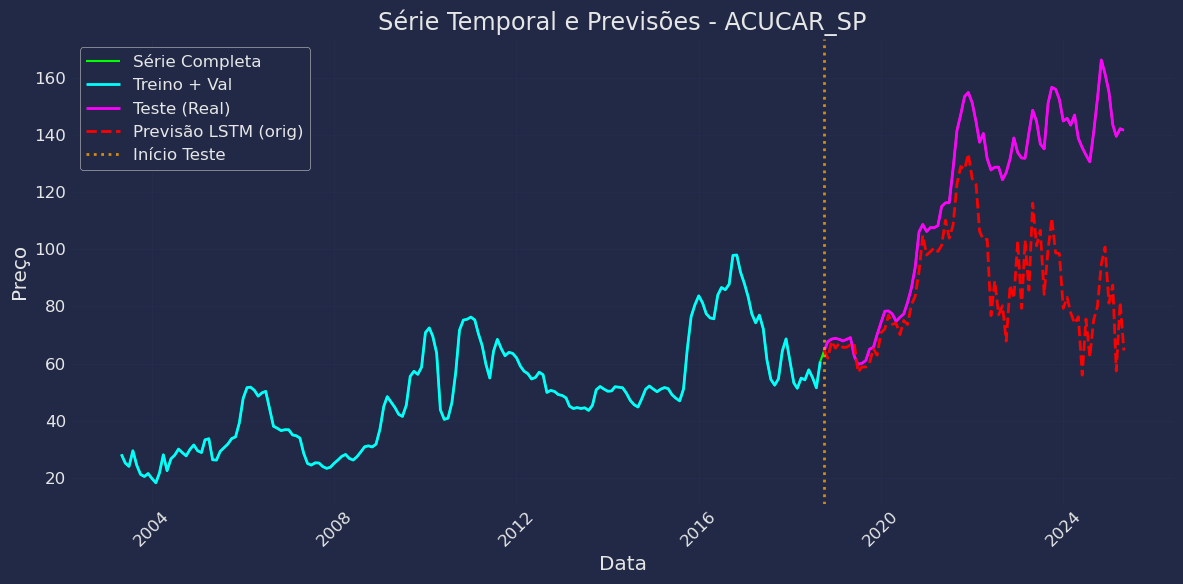

In [27]:
plot_series_and_forecasts(df_brl, full_train, test, forecasts_df)

In [ ]:
# https://www.nature.com/articles/s41598-025-05103-z?fromPaywallRec=false#Sec15
# https://www.mdpi.com/2227-9091/11/2/27
# https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=10908409
# https://www.mdpi.com/2072-4292/15/8/2076
# https://www.sciencedirect.com/science/article/pii/S2467967423000880?via%3Dihub
# https://www.wne.uw.edu.pl/application/files/4016/7775/9406/WNE_WP412.pdf
# https://jatit.org/volumes/Vol102No24/8Vol102No24.pdf
# https://inass.org/wp-content/uploads/2023/03/2023083114-2.pdf
# https://www.mdpi.com/2227-7390/11/6/1432
# https://www.nature.com/articles/s41598-024-69418-z/tables/2
# https://pmc.ncbi.nlm.nih.gov/articles/PMC12022274
# file:///Downloads/s00521-024-09679-x%20(5).pdf

In [ ]:
def optuna_tunning_por_serie(df_brl, train, val, n_lags=12, n_trials=20):
    best_models = {}
    best_scalers = {}
    mae_summary = []

    for uid in df_brl['unique_id'].unique():
        print(f"\n🔍 Tunando série {uid}")

        df_train_uid = train[train["unique_id"] == uid].reset_index(drop=True)
        df_val_uid = val[val["unique_id"] == uid].reset_index(drop=True)
        df_full_train_uid = pd.concat([df_train_uid, df_val_uid]).reset_index(drop=True)

        # pular séries curtas
        if len(df_train_uid) <= n_lags:
            print(f"Pulando {uid}: treino tem {len(df_train_uid)} pontos (<= n_lags={n_lags}).")
            continue

        study = optuna.create_study(direction="minimize")
        # envolver objective com os DataFrames à mão
        study.optimize(lambda trial: objective(trial, df_train_uid, df_val_uid, n_lags=n_lags),
                       n_trials=n_trials, show_progress_bar=True)

        if study.best_value is None or study.best_params is None:
            print(f"Não foi possível encontrar bons parâmetros para {uid}. Pulando.")
            continue

        print("Melhores parâmetros:", study.best_params)
        best_params = study.best_params

        # ---- Treina modelo final com TREINO + VALIDAÇÃO (fit scaler no full_train) ----
        # preparar scaler
        y_full = df_full_train_uid["y"].values.reshape(-1, 1)
        scaler_full = MinMaxScaler(feature_range=(0, 1))
        y_full_scaled = scaler_full.fit_transform(y_full).flatten()

        # criar janelas para treino final
        X_full, y_full_jan = criar_janelas_array(y_full_scaled, n_lags=n_lags)
        if X_full is None:
            print(f"Histórico combinado insuficiente para {uid}. Pulando final training.")
            continue

        # montar e treinar modelo final
        model = Sequential()
        model.add(LSTM(best_params['n_units'], input_shape=(n_lags, 1)))
        if best_params.get('dropout', 0.0) > 0:
            model.add(Dropout(best_params['dropout']))
        model.add(Dense(best_params['dense_units'], activation=best_params['activation']))
        model.add(Dense(1))

        model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']), loss='mse')
        es = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True, verbose=0)
        model.fit(X_full, y_full_jan, epochs=best_params['epochs'],
                  batch_size=best_params['batch_size'], verbose=0, callbacks=[es])

        # salvar modelo e scaler
        best_models[uid] = model
        best_scalers[uid] = scaler_full

        # opcional: calcular MAE no conjunto de validação com o modelo final (previsão one-step usando val)
        # vamos gerar previsões na escala original para val
        df_preds_val = treinar_e_prever_lstm_single_series(best_params, df_train_uid, df_val_uid, n_lags=n_lags)
        if not df_preds_val.empty:
            mae_val = mae_from_forecasts(df_preds_val, df_val_uid, model_col='lstm')
        else:
            mae_val = np.nan
        mae_summary.append({"unique_id": uid, "mae_val": mae_val, "best_value_in_study": study.best_value})

    mae_df = pd.DataFrame(mae_summary).sort_values("mae_val")
    return best_models, best_scalers, mae_df